**1. Import Necessary Libraries**

In [1]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import pandas as pd
import numpy as np
import math
import time
import re


### **Pre-processing checklist**

### **1. Load CSV and add column names (Pima: pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, diabetes_pedigree_function, age, outcome).**

**2. To read the data into Python.**

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()    # Check if every attribute has appropriate data types and count of records in each attribute

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### **DATA CLEANING**

**3. Rename Columns**

In [4]:
def pascal_to_snake(pascal_case_string):
    """Converts a PascalCase string to snake_case."""
    # Insert underscore before each uppercase letter (except the first)
    s1 = re.sub(r'(.)([A-Z])', r'\1_\2', pascal_case_string)
    # Convert the entire string to lowercase
    return s1.lower()

In [5]:
cols = df.columns
for col in cols:
    if col == 'BMI':
        snake_case_col = 'bmi'
    else:
        snake_case_col = pascal_to_snake(col)
    df = df.rename ({col: snake_case_col}, axis =1)   # renaming since the original name had a currency symbol
df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### **2. Check for missing values (in Pima some 0 values are placeholders for missing in glucose, blood_pressure, skin_thickness, insulin, bmi). Decide how to handle (imputation with median or remove rows). Document your choice.**

**4. Check For any missing Values**

In [6]:
print(df.isnull().sum())    # return total no. of null values in each attribute

pregnancies                   0
glucose                       0
blood_pressure                0
skin_thickness                0
insulin                       0
bmi                           0
diabetes_pedigree_function    0
age                           0
outcome                       0
dtype: int64


**5. Dealing with Inconsistent Data**

In [7]:
numerical_cols = df.select_dtypes(include=np.number).columns    # return the names of attributes that are of numerical types like integer or float or decimal
print(numerical_cols)

Index(['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin',
       'bmi', 'diabetes_pedigree_function', 'age', 'outcome'],
      dtype='object')


In [8]:
# Check if any attribute has negative value as these are quantitative attributes and can only have positive values
for col in numerical_cols:
    invalid = df[df[col] < 0]   # Create a new DataFrame containing only the rows where the value in the current column is negative

    if not invalid.empty:
        count = invalid[col].count()
        print(f"Invalid (negative) values found in '{col}': {count}")
        print("-" * 30) # Print a separator for better readability

In [9]:
# Check if any attribute has zero as value
print("Zero as values found in")
for col in numerical_cols:
    invalid = df[df[col] == 0]   # Create a new DataFrame containing only the rows where the value in the current column is negative

    if not invalid.empty:
        count = invalid[col].count()
        print(f"{col}: {count}")

Zero as values found in
pregnancies: 111
glucose: 5
blood_pressure: 35
skin_thickness: 227
insulin: 374
bmi: 11
outcome: 500


**Observation of Step 5:**

* Zeroes in `pregnancies` is a `valid` value, meaning the person haven't been pregrnant.
* Zeros in `outcome` indicates `negative` class.
* But other attributes cannot have zero as their value which means they indicate `missing` values.
* There is only 768 records, so using remove rows to handle data cleaning can result in loss of data.
* Can use `mean` or `median`. for better performance KNN imputation technique can be used.
* If a feature is skewed, then use median else mean.

-------
**SUMMARY OF DATA CLEANING:**

-------

- Renamed Columns.
- No negative values in any attributes.
- Missing values found.
- Use descriptive statistical analysis to either use mean imputation or median imputation

### **ANALYZE DATA AND APPLY IMPUTATION TECHNIQUE**

**6. Numerical Summary**

In [10]:
df.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Observation of step 6:**
- `Outliers` detected in `pregnancies` attribute because mean=3.84 but max=17.
- zeros as min in glucode, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction shows missing values.
-  25% of SkinThickness and insulin is 0 which shows there is lot of `missing` values.
- For `insulin`, max = 846 but mean = 80 so less data with few having very large outcomes indicating `outliers` and std > mean indicates `skewness`.
- `Outliers` detected in `age` attribute because mean=33, 50%=29 but max=81.
- missing_value_cols = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function']

**7. Plot mean, median, mode, skewness and coefficient of variation (CV)**

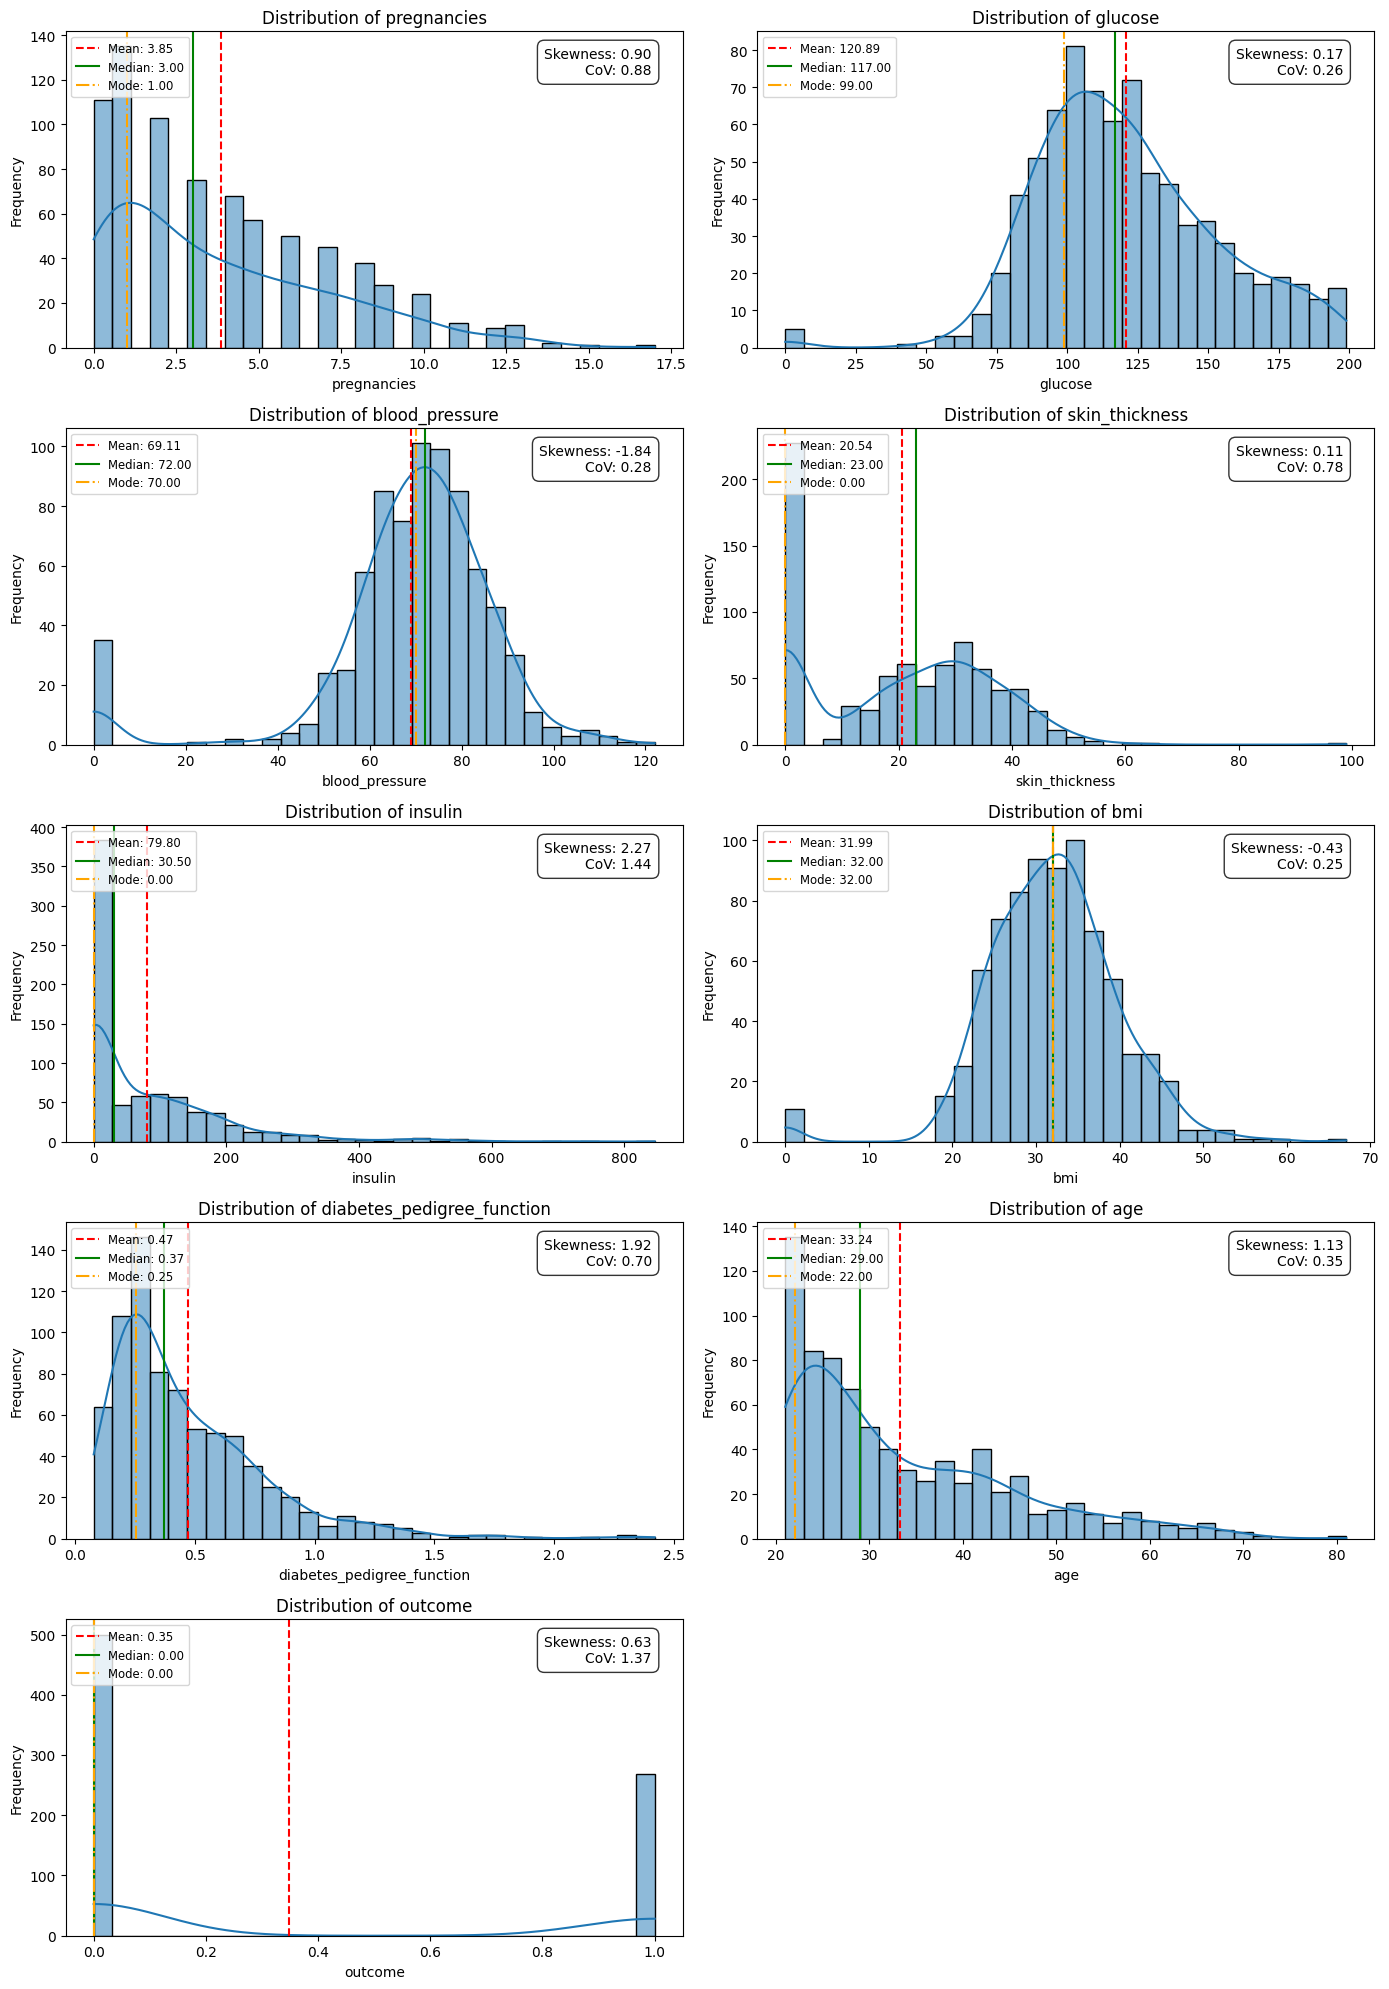

In [11]:
# The mean, median, mode, skewness and coefficient of variation (CV) are indicated on the plots to decide on imputation technique.

nrows = math.ceil(len(numerical_cols) / 2)
plt.figure(figsize=(14, nrows * 4))

for i, col in enumerate(numerical_cols):
    plt.subplot(nrows, 2, i + 1)
    
    # Calculate key statistics
    mean = df[col].mean()
    median = df[col].median()
    mode = df[col].mode()[0] if not df[col].mode().empty else None
    std_dev = df[col].std()
    
    # Calculate Skewness and Coefficient of Variation (CoV) using scipy's skewness to get a unbiased version of skewness
    skewness = skew(df[col], nan_policy='omit')
    cov = (std_dev / mean) if mean != 0 else np.inf

    # Plot the histogram
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Plot lines for mean, median, and mode
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.2f}')
    if mode is not None:
        plt.axvline(mode, color='orange', linestyle='-.', label=f'Mode: {mode:.2f}')
    
    # Add a text box with the statistics
    stats_text = f"Skewness: {skewness:.2f}\n" \
                 f"CoV: {cov:.2f}"
    
    plt.legend(loc='upper left', fontsize='small')
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

-------
**SUMMARY OF DESCRIPTIVE STATISTICAL ANALYSIS:**

-------
*  The **insulin** feature has a **`higher CoV`**. This means that insulin is more spread out. This is an important insight that further emphasizes the need for feature scaling.
* The attributes **diabetes_pedigree_function** and **skin_thickness** are **`moderately distributed`** while others are closely distributed.
* For **diabetes_pedigree_function** and **insulin**, **`mean >> median`** while for other attributes they are approximately equal.
* **Skewness**: The **blood_pressure** is left-skewed and attributes **insulin** and **diabetes_pedigree_function** is right-skewed. 
* The mean will be pulled down by outliers in skewed attributes, using the median imputation is a more robust choice. Use mean for other attributes.

**8. Mean and Median Imputation**

In [12]:
df['blood_pressure'] = df['blood_pressure'].replace(0,df['blood_pressure'].median())
df['insulin'] = df['insulin'].replace(0,df['insulin'].median())
df['diabetes_pedigree_function'] = df['diabetes_pedigree_function'].replace(0,df['diabetes_pedigree_function'].median())

df['glucose'] = df['glucose'].replace(0,df['glucose'].mean())
df['skin_thickness'] = df['skin_thickness'].replace(0,df['skin_thickness'].mean())
df['bmi'] = df['bmi'].replace(0,df['bmi'].mean())

### **EXPLORATORY DATA ANALYSIS**

**9. Univariate Analysis: Analysis on numerical Variables**

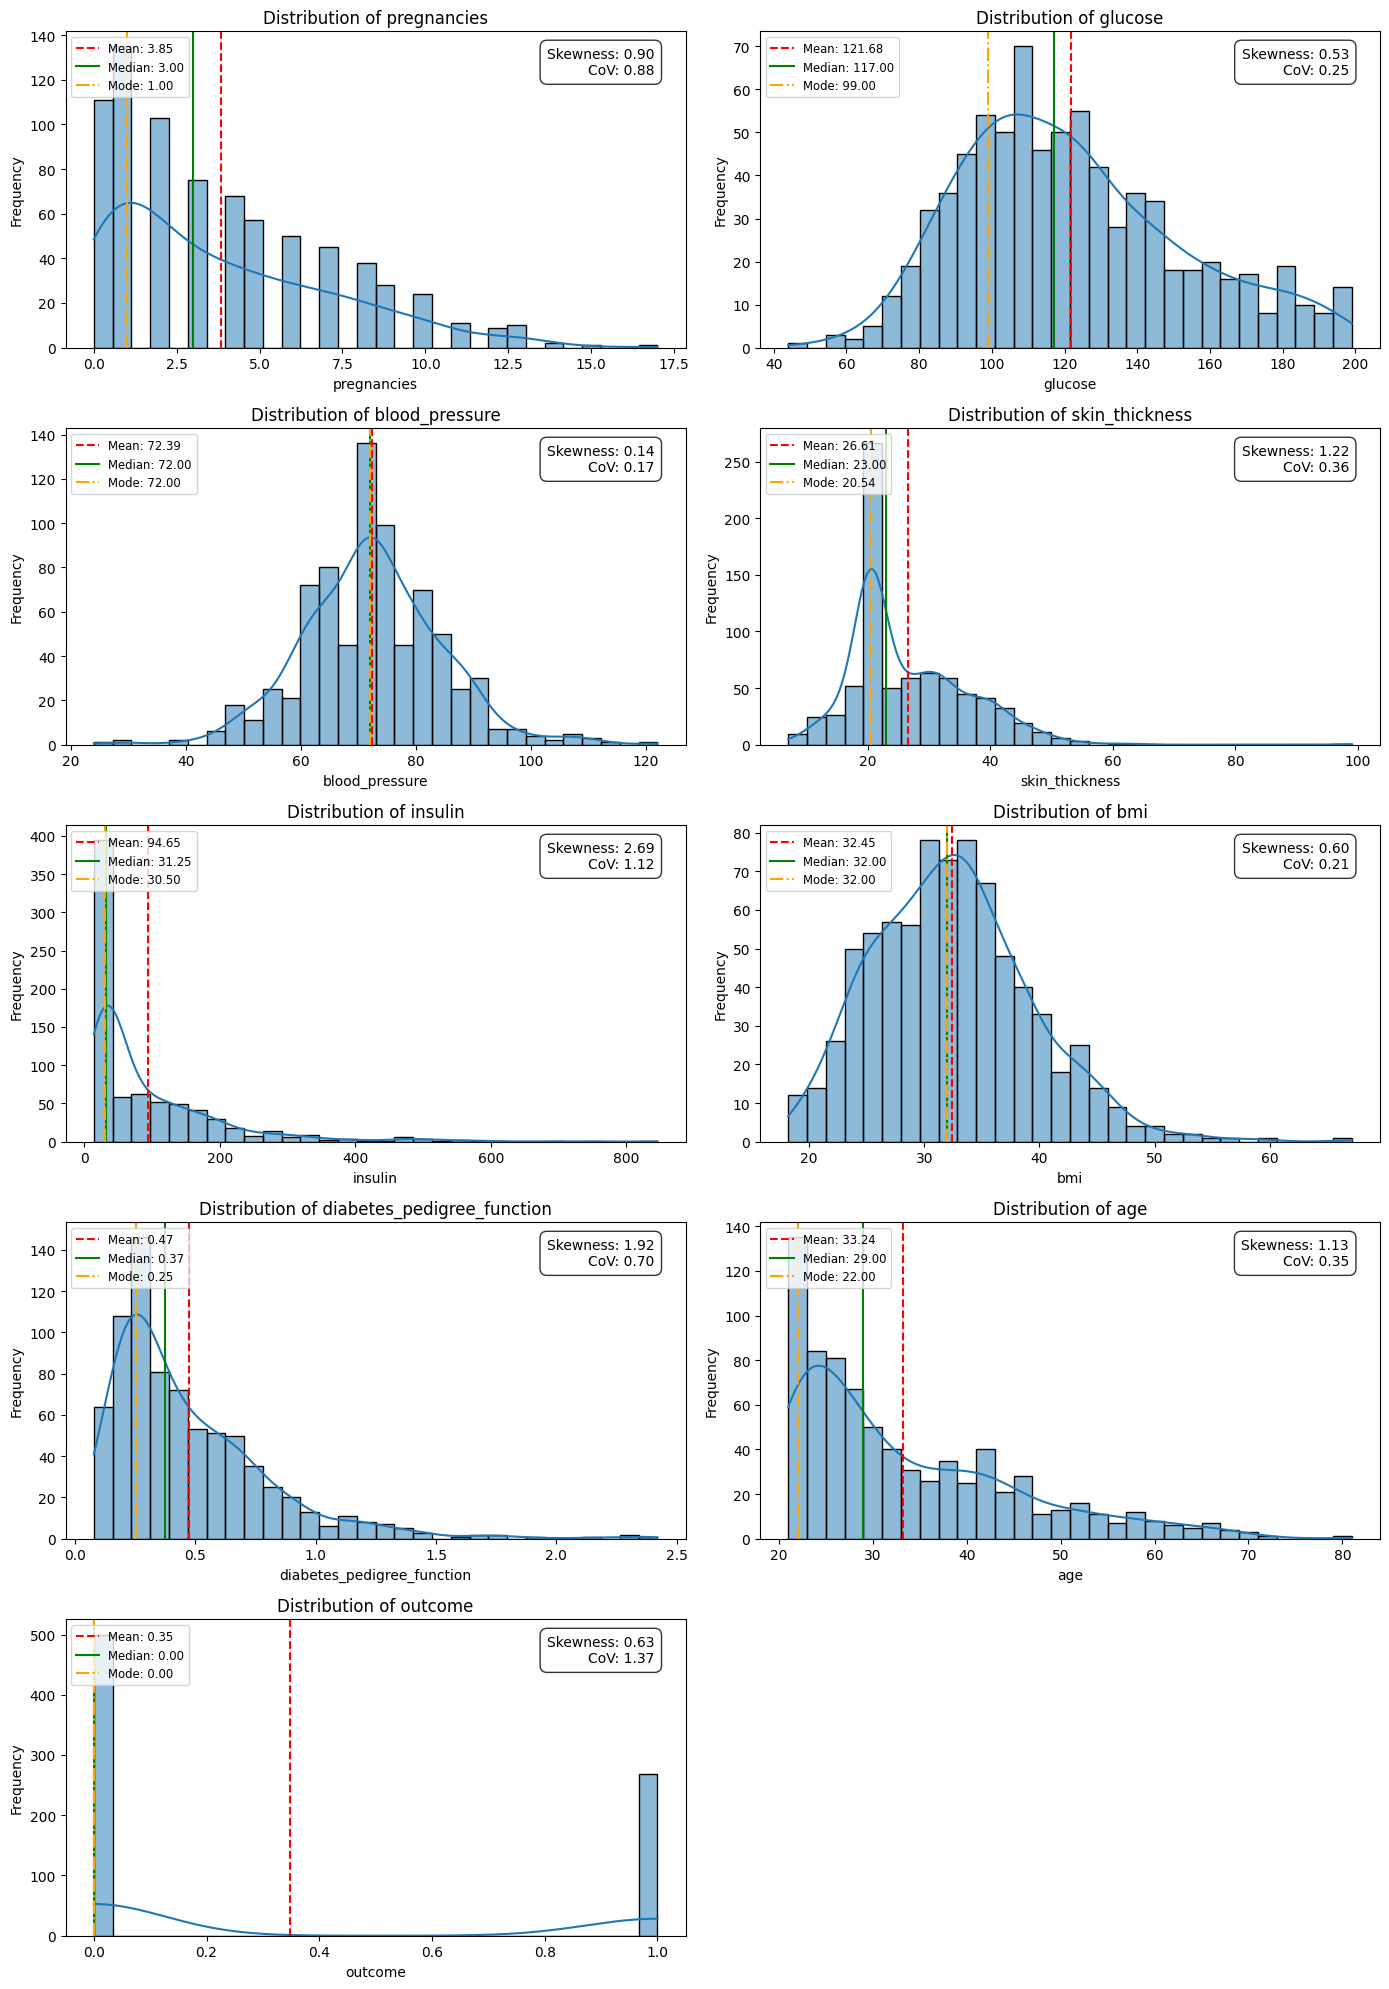

In [13]:
# Visualize distributions of numerical columns using Histogram plot
# This helps to understand the distribution and identify any potential outliers.
# Kernel Density Estimation (KDE) is also plotted to visualize the distribution shape.
# The mean, median, and mode are indicated on the plots for reference.
# Additionally, the skewness is displayed to understand the asymmetry of the distribution.
# The coefficient of variation (CV) is also shown to assess the relative variability.

nrows = math.ceil(len(numerical_cols) / 2)
plt.figure(figsize=(14, nrows * 4))

for i, col in enumerate(numerical_cols):
    plt.subplot(nrows, 2, i + 1)
    
    # Calculate key statistics
    mean = df[col].mean()
    median = df[col].median()
    mode = df[col].mode()[0] if not df[col].mode().empty else None
    std_dev = df[col].std()
    
    # Calculate Skewness and Coefficient of Variation (CoV) using scipy's skewness to get a unbiased version of skewness
    skewness = skew(df[col], nan_policy='omit')
    cov = (std_dev / mean) if mean != 0 else np.inf

    # Plot the histogram
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Plot lines for mean, median, and mode
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.2f}')
    if mode is not None:
        plt.axvline(mode, color='orange', linestyle='-.', label=f'Mode: {mode:.2f}')
    
    # Add a text box with the statistics
    stats_text = f"Skewness: {skewness:.2f}\n" \
                 f"CoV: {cov:.2f}"
    
    plt.legend(loc='upper left', fontsize='small')
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

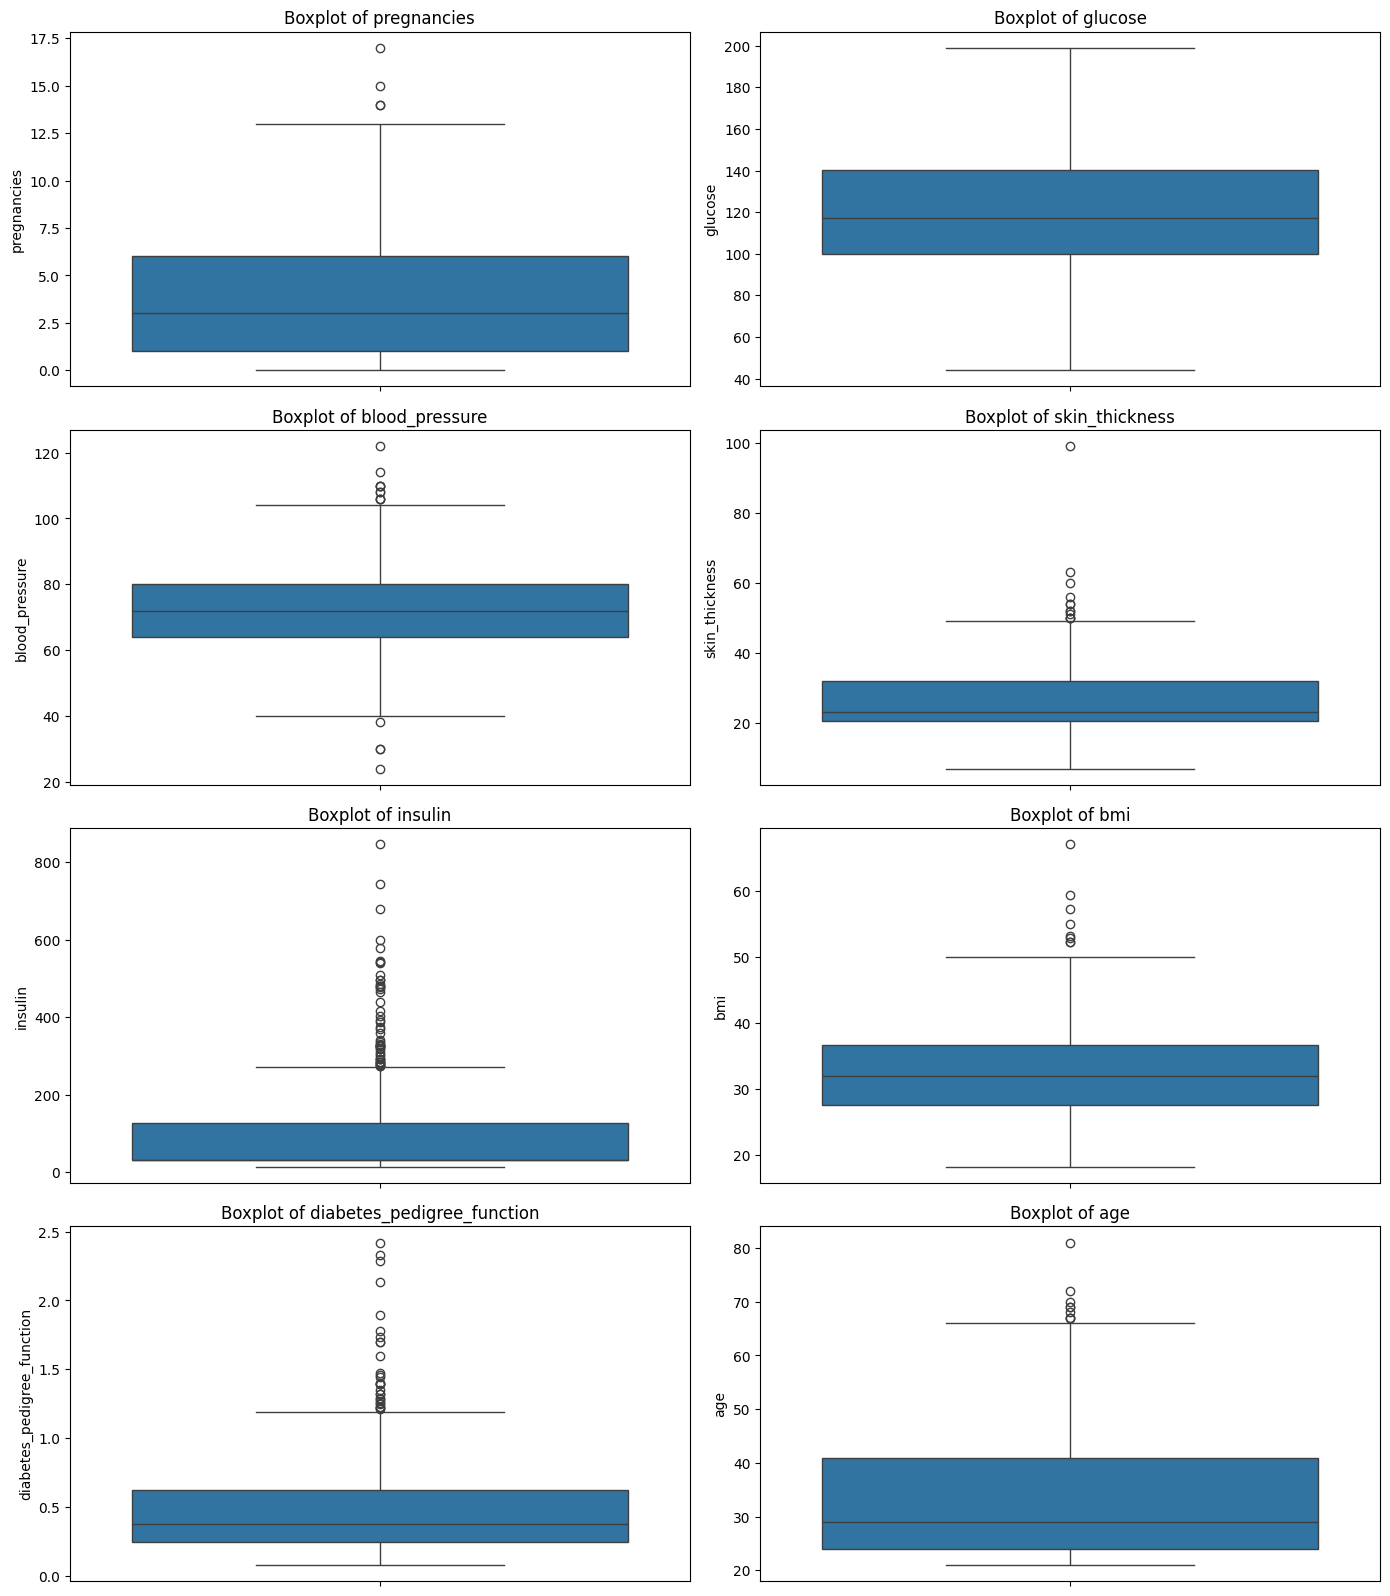

In [14]:
# Visualize distributions of numerical columns using Box plot

nrows = math.ceil(len(numerical_cols) / 2)
plt.figure(figsize=(14, nrows * 4))

for i, col in enumerate(numerical_cols):
    if col != 'outcome':
        plt.subplot(nrows, 2, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)

plt.tight_layout()
plt.show()

**Observation Of Step 9 (After applying imputation):**
* For diabetes_pedigree_function and insulin, `mean >> median` with a long tail (strongly right-skewed) while for other attributes they are approximately equal.
* The attributes pregnancies, skin_thickness, insulin, age and diabetes_pedigree_function is highly `skewed` while glucose and bmi is slightly skewed. => **Log transformation**
* The attributes pregnancies, diabetes_pedigree_function and insulin is `more spread out` while others are closely distributed. => **Feature Scaling**
* From boxplot, we learn that there is presence of `outliers` in all the attributes except for glucose. => **Data Transformation or Do nothing**.

**10. Explore Relationship between variables: Correlation Coefficient Heatmap**

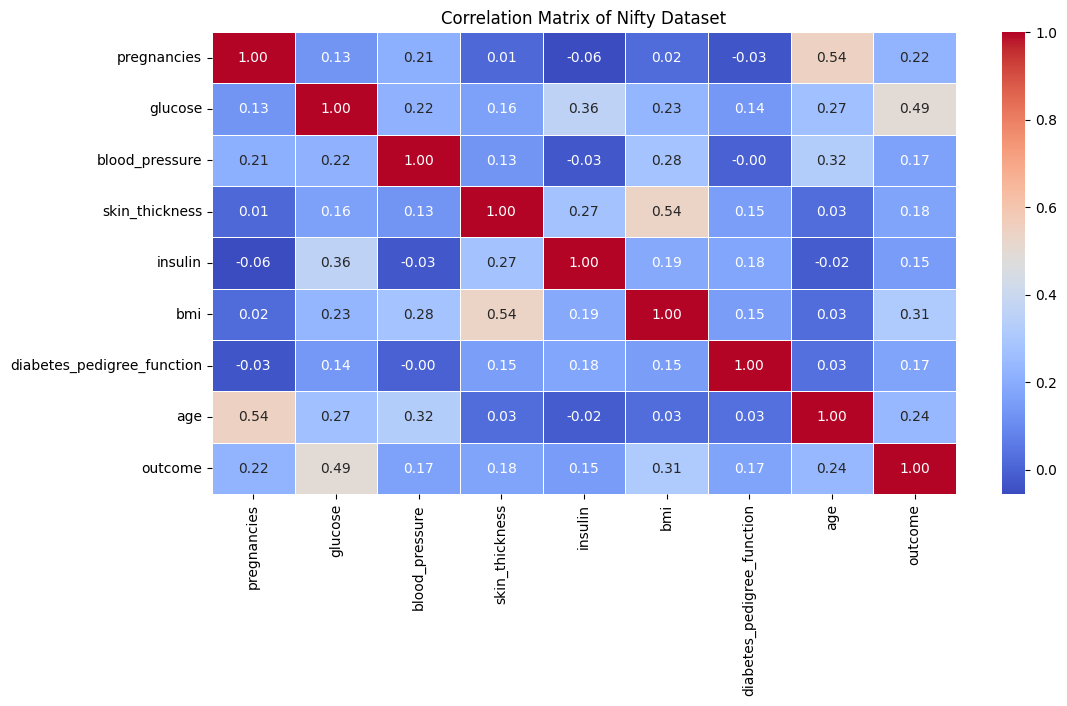

In [15]:
# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Nifty Dataset')
plt.show()

**11. Check for class labels distribution**

Class counts:
outcome
0    500
1    268
Name: count, dtype: int64

 ----------
Class percetages
outcome
0    65.104167
1    34.895833
Name: count, dtype: float64

 ----------
Class distribution


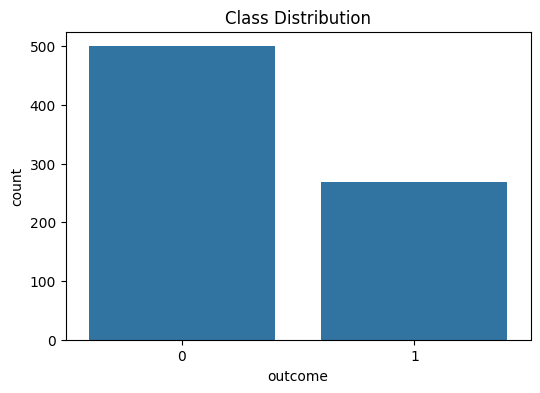

In [16]:
print("Class counts:")
class_counts = df['outcome'].value_counts()
print(class_counts)

print("\n", "-"*10)
print("Class percetages")
total_samples = len(df)
class_percentages = (class_counts / total_samples) * 100
print(class_percentages)

print("\n", "-"*10)
print("Class distribution")
plt.figure(figsize=(6, 4))
sns.countplot(x='outcome', data=df)
plt.title('Class Distribution')
plt.show()

------
**SUMMARY OF EDA:**

------
- To Handle Outliers: ['pregnancies', 'blood_pressure', 'insulin', 'diabetes_pedigree_function', 'skin_thickness', 'bmi', 'age'], 
    - Do nothing (or)
    - Remove outlier records (or)
    - Drop the attributes if not needed (or)
    - Transform the data
- The dataset is imbalanced.
    - can lead to accuracy paradox (the model can achieve high accuracy just by predicting as 'No' for every input, so doesn't learn about minority class), 
    - can lead to poor minority class performance (check confusion matrix, recall, and f1-score of minority class)
    - use oversampling or undersampling to fix this issue.
    - Address Class Imbalance with SMOTE (preferred).
- Correlation with the outcome Variable
    - glucose: Has the strongest positive correlation with the outcome at 0.49.
    - bmi, pregnancies, age: Shows a weak positive correlation.
    - blood_pressure, skin_thickness, insulin, and diabetes_pedigree_function: Show very weak correlations with the outcome.
- Multicollinearity
    - age and pregnancies: Show a moderate positive correlation of 0.54. This makes sense, as the number of pregnancies a woman has may increase with age.
    - bmi and skin_thickness: Have a moderate positive correlation of 0.54.
    - Collinearity between other combination of variables are very weak.

### **DATA PREPROCESSING**

**12. Handling Outliers**

In [17]:
outlier_cols = ['pregnancies', 'blood_pressure', 'insulin', 'diabetes_pedigree_function', 'skin_thickness', 'bmi', 'age']
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of outliers detected: {len(outliers)}")

    df[col] = np.where(df[col] > upper_bound, upper_bound,
                                    np.where(df[col] < lower_bound, lower_bound, df[col]))

Number of outliers detected: 4
Number of outliers detected: 14
Number of outliers detected: 49
Number of outliers detected: 29
Number of outliers detected: 12
Number of outliers detected: 8
Number of outliers detected: 9


### **MODEL DEVELOPMENT**

### **QUESTION1 — Validation set (holdout)**

**a. Randomly split the data into training (70%) and holdout test (30%) sets (set a random seed and report it).**

**b. On the training set, further split into train (80%) and validation (20%) (or simply use a single split: training 70% and validation 30% — be explicit).**    

In [18]:
X = df.drop(['outcome'], axis=1)     # axis = 1 for dropping columns & if axis = 0 it drops rows
y = df['outcome']
random_state = 42

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)   # 70-30 train-test split, random_state for reproducibility
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=random_state
)
print("X_train_full shape:", X_train_full.shape)
print("y_train_full shape:", y_train_full.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

scaler = StandardScaler()   # Standardize features by removing the mean and scaling to unit variance (z-score normalization)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
x_test_scaled = scaler.transform(X_test)

X_train_full shape: (537, 8)
y_train_full shape: (537,)
X_train shape: (429, 8)
y_train shape: (429,)
X_test shape: (231, 8)
y_test shape: (231,)
X_val shape: (108, 8)
y_val shape: (108,)


**c. Train a logistic regression classifier (use scikit‑learn's LogisticRegression or implement from scratch) with default regularization first.**

**d. Report training, validation, and holdout test accuracy, precision, recall, F1, and ROC‑AUC.**

In [19]:
def report_metrics(y_true, y_pred, y_prob, label):
    cl_report = classification_report(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"--- {label} Performance ---")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(cl_report)
    print()

lr_model = LogisticRegression(random_state=random_state)
lr_model.fit(X_train_scaled, y_train)

y_train_pred = lr_model.predict(X_train_scaled)
y_train_prob = lr_model.predict_proba(X_train_scaled)[:, 1]
report_metrics(y_train, y_train_pred, y_train_prob, "Training Set")

y_val_pred = lr_model.predict(X_val_scaled)
y_val_prob = lr_model.predict_proba(X_val_scaled)[:, 1]
report_metrics(y_val, y_val_pred, y_val_prob, "Validation Set")

y_test_pred = lr_model.predict(x_test_scaled)
y_test_prob = lr_model.predict_proba(x_test_scaled)[:, 1]
report_metrics(y_test, y_test_pred, y_test_prob, "Holdout Test Set")

--- Training Set Performance ---
ROC-AUC:   0.8457
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       280
           1       0.73      0.57      0.64       149

    accuracy                           0.78       429
   macro avg       0.76      0.73      0.74       429
weighted avg       0.77      0.78      0.77       429


--- Validation Set Performance ---
ROC-AUC:   0.9153
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        69
           1       0.83      0.51      0.63        39

    accuracy                           0.79       108
   macro avg       0.80      0.73      0.74       108
weighted avg       0.80      0.79      0.77       108


--- Holdout Test Set Performance ---
ROC-AUC:   0.8016
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       151
           1       0.65      0.60      0.62        80

    accuracy         

<table>
<tr><td>Metric</td>	<td>Training Set</td>	<td>Validation Set</td>	<td>Holdout Test Set</td></tr>
<tr><td>Accuracy</td>	<td>0.78</td>	<td>0.79</td>	<td>0.75</td></tr>
<tr><td>Precision (Class 1)</td>	<td>0.73</td>	<td>0.83</td>	<td>0.65</td></tr>
<tr><td>Recall (Class 1)</td>	<td>0.57</td>	<td>0.51</td>	<td>0.60</td></tr>
<tr><td>F1-Score (Class 1)</td>	<td>0.64</td>	<td>0.63</td>	<td>0.62</td></tr>
<tr><td>ROC-AUC</td>	<td>0.85</td>	<td>0.92</td>	<td>0.80</td></tr>
</table>

**Answer of Question 1 - c&d**

* Training set - The portion of the data the model learns from.
* Validation set - Used during training to test and tune hyperparameters.
* Testing set - to get an unbiased estimate of the model's final performance.
* The dataset we have is an imbalanced dataset with class 0 count is 280 and class 1 count is 149 in training. Likewise, in validation set 69:39 and in test dataset 151:80. So a naive model that ignores the minority class entirely can still look decent by just having a high accuracy score.

For Accuracy,
* A naive model will achieve 280/429=65%, but our model on training achieved 78%, which is pretty good.
* Similary, in validation dataset, naive model will achieve 64% but our model achieved 79%.
* And in testing dataset, naive model will achieve 65% but our model achieved 75%.
* So, we conclude there is no accuracy paradox.
* There is a noticeable drop from 0.79 to 0.75 but not extreme.
* This may be because the `characteristics of the test dataset are likely different` from the training and validation datasets, maybe due to data skew, or temporal shift or feature importance.

For precision and recall,
* In training dataset, 
    * when the model predicts class 0, 80% of the time is correct and it is 89% out of all actual class 0 but 
    * when it is class 1, 73% of the time it is correct but only 57% of all actual class 1 is correct. It misses 43% of class 1's to predict correctly.
* Similarly, in validation dataset, 
    * the model predicts 77% of the time correctly, which is 94% of all actual class 0 but 
    * when it is class 1, 83% of the time it is correct but only 51% of all actual class 1 is correct, missing out 49% of class 1's.
* And in test dataset, similar behaviour occurs for both class 1 and class 0.
* The model's ability to correctly identify positive cases (Class 1) plunges from 83% pecision on the validation set to only 65% on the test set.
* The better recall in test set (51 to 60%) indicates that the model is finding a higher percentage of the actual positive cases in the test set, but at the cost of more false positives.
* So clearly `the low recall for the minority class` tells the model is `struggling to correctly identify the "1" outcomes`. 
* This is a direct consequence of the data imbalance, and it's what needed to focus on improving. 

For F1-score,
* The difference in F1-score among train, test and validation dataset is not high.
* In train set, f1-score of class 0 to class 1 is 84 & 64, for test set, it is 85 & 63, and for validation set, it is 81 & 62.
* But we could say that for any dataset, the model has very low F1-score for minority class.

For ROC-AUC,
* A high ROC-AUC score indicates that the model is very good at separating the classes.
* For train, it is 84, in val is 92, and in test is 80.
* The substantial decrease indicates a clear loss of discriminative power on the new data.

Finally,
* The fact that the ROC-AUC is good but the recall of minority class is low indicates that the model has high confidence in its majority class predictions but is less confident and less accurate in correctly finding all of the minority class instances.

In [20]:
test_errors = []
test_error = 1 - lr_model.score(X_val_scaled, y_val)
test_errors.append(test_error)
print(f"Prediction Error on Holdout Validation Set: {test_error:.4f}")
print(f"Standard Deviation of Prediction Error on Holdout Validation Set: {np.std(test_errors):.4f}")

Prediction Error on Holdout Validation Set: 0.2130
Standard Deviation of Prediction Error on Holdout Validation Set: 0.0000


**e. How sensitive is the validation estimate to the random split? Repeat the holdout (re‑randomize) 30 times and report mean and standard deviation of validation error.**

In [21]:
val_errors = []
train_errors = []
for i in range(30):
    X_train_loop, X_val_loop, y_train_loop, y_val_loop = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=i
    )
    
    X_train_loop_scaled = scaler.fit_transform(X_train_loop)
    X_val_loop_scaled = scaler.transform(X_val_loop)

    lr_model = LogisticRegression(random_state=random_state)
    lr_model.fit(X_train_loop_scaled, y_train_loop)
    val_error = 1 - lr_model.score(X_val_loop_scaled, y_val_loop)
    val_errors.append(val_error)

    train_error = 1 - lr_model.score(X_train_loop_scaled, y_train_loop)
    train_errors.append(train_error)

# Report mean and standard deviation of validation error
print("---- At Validation Set ----")
print(f"Validation errors over 30 runs: {val_errors}")
print(f"The range of validation errors: {min(val_errors):.4f} to {max(val_errors):.4f}")
print(f"Mean validation error over 30 runs: {np.mean(val_errors):.4f}")
print(f"Standard deviation of validation error: {np.std(val_errors):.4f}")

# Report mean and standard deviation of training error
print("\n---- At Training Set ----")
print(f"Training errors over 30 runs: {train_errors}")
print(f"The range of training errors: {min(train_errors):.4f} to {max(train_errors):.4f}")
print(f"Mean training error over 30 runs: {np.mean(train_errors):.4f}")
print(f"Standard deviation of training error: {np.std(train_errors):.4f}")

---- At Validation Set ----
Validation errors over 30 runs: [0.2777777777777778, 0.18518518518518523, 0.2592592592592593, 0.2222222222222222, 0.2314814814814815, 0.2407407407407407, 0.20370370370370372, 0.3055555555555556, 0.13888888888888884, 0.2407407407407407, 0.2222222222222222, 0.20370370370370372, 0.2222222222222222, 0.2870370370370371, 0.2129629629629629, 0.2407407407407407, 0.2407407407407407, 0.17592592592592593, 0.20370370370370372, 0.2129629629629629, 0.25, 0.2314814814814815, 0.18518518518518523, 0.2592592592592593, 0.19444444444444442, 0.14814814814814814, 0.18518518518518523, 0.16666666666666663, 0.25, 0.25]
The range of validation errors: 0.1389 to 0.3056
Mean validation error over 30 runs: 0.2216
Standard deviation of validation error: 0.0385

---- At Training Set ----
Training errors over 30 runs: [0.20512820512820518, 0.22843822843822847, 0.2097902097902098, 0.21678321678321677, 0.21678321678321677, 0.21212121212121215, 0.21678321678321677, 0.19347319347319347, 0.2307

**Answer Of Question 1 - e:**
* Validation Estimate: It's a single value performance metric that tells how well the model performed on that specific, held-out dataset.
* By keeping the data split consistent (same random seed), we can confidently say that any changes in performance are due to the model or hyperparameter tuning, not because we got a different data split.
* We use different random seeds here, so to understand the characteristics of the dataset accross the dataset if it is consistent or varying.
* The validation error ranges from 0.305 to 0.139. Its mean is 0.2216 and its standard deviation is 0.0385
* If a split has an error of 0.139, then it means the model could predict them easily
* But if it is high, then the validation split contains characteristics that are not well-represented in the training data.
* By running the experiment 30 times, we get a much more reliable sense of the model's average performance and its variability.
* We could say on average, the model makes a mistake of 22% of the time. This is very low that it predicts only 22% of the data wrongly. So, stable and trustworthy.
* When it comes to standard deviation, it is 0.0385. It doesn't matter which 20% of the data is held out for validation; the error will consistently be around 22%. This means the model has learned generalizable patterns, not just the specifics of a single training set. 
* So, not very sensitive to random split.

### **Q2 — k‑Fold Cross‑Validation**
**a. Implement k‑fold CV with k = 5 and k = 10 using both non‑stratified and stratified versions (use KFold and StratifiedKFold).**

**b. For each setting, compute the mean cross‑validation error and its standard deviation (report accuracy and ROC‑AUC at minimum).**

In [22]:
lr_model = LogisticRegression(random_state=random_state)

def perform_kfold_cv(n_splits, X_data, y_data, stratified=False):
    print(f"--- {n_splits}-Fold {'Stratified' if stratified else 'Non-Stratified'} Cross-Validation ---")
    
    if stratified:
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        
    val_error = []
    val_roc_aucs = []
    train_acc, val_acc = [], []
    
    # Iterate through each fold
    for train_index, val_index in kf.split(X_data, y_data):
        X_train_fold, X_val_fold = X_data.iloc[train_index], X_data.iloc[val_index]
        y_train_fold, y_val_fold = y_data.iloc[train_index], y_data.iloc[val_index]
        
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        lr_model.fit(X_train_fold_scaled, y_train_fold)
        
        y_train_pred = lr_model.predict(X_train_fold_scaled)
        train_acc.append(accuracy_score(y_train_fold, y_train_pred))
        
        y_val_pred = lr_model.predict(X_val_fold_scaled)
        y_val_prob = lr_model.predict_proba(X_val_fold_scaled)[:, 1]
        
        val_error.append(1- accuracy_score(y_val_fold, y_val_pred))
        val_acc.append(accuracy_score(y_val_fold, y_val_pred))
        val_roc_aucs.append(roc_auc_score(y_val_fold, y_val_prob))
    
    print(f"Mean Error: {np.mean(val_error):.4f} (Standard Deviation: {np.std(val_error):.4f})")
    print(f"At validation, Min accuracy: {np.min(val_acc):.4f}  |  Min ROC-AUC:  {np.min(val_roc_aucs):.4f}")
    print(f"At training,   Min accuracy: {np.min(train_acc):.4f}")
    print()

In [23]:
perform_kfold_cv(n_splits=5, X_data=X_train_full, y_data=y_train_full, stratified=False)
perform_kfold_cv(n_splits=5, X_data=X_train_full, y_data=y_train_full, stratified=True)

--- 5-Fold Non-Stratified Cross-Validation ---
Mean Error: 0.2235 (Standard Deviation: 0.0115)
At validation, Min accuracy: 0.7593  |  Min ROC-AUC:  0.8133
At training,   Min accuracy: 0.7786

--- 5-Fold Stratified Cross-Validation ---
Mean Error: 0.2272 (Standard Deviation: 0.0395)
At validation, Min accuracy: 0.7290  |  Min ROC-AUC:  0.8015
At training,   Min accuracy: 0.7669



In [24]:
perform_kfold_cv(n_splits=10, X_data=X_train_full, y_data=y_train_full, stratified=False)
perform_kfold_cv(n_splits=10, X_data=X_train_full, y_data=y_train_full, stratified=True)

--- 10-Fold Non-Stratified Cross-Validation ---
Mean Error: 0.2215 (Standard Deviation: 0.0510)
At validation, Min accuracy: 0.6792  |  Min ROC-AUC:  0.7709
At training,   Min accuracy: 0.7764

--- 10-Fold Stratified Cross-Validation ---
Mean Error: 0.2252 (Standard Deviation: 0.0536)
At validation, Min accuracy: 0.6852  |  Min ROC-AUC:  0.7414
At training,   Min accuracy: 0.7743



**c. Compare the 5‑fold and 10‑fold estimates. Which gives lower variance? Which is more biased (if you can reason about bias)?**

**ans:** On comparing 5-fold and 10-fold estimates,
* A low accuracy on the training set indicates high bias. 
* 5-Fold divides the data into 80% for training and 20% for validating while 10-Fold divides the data into 90% for training and 10% for validating.
* A model trained on more data is a better approximation of the model trained on the entire dataset, so 10-fold has less bias.
* Again, comparatively 5-Fold achieves less than 10-Fold, so 5-fold is more biased.
* A lower variance is the one which has less difference between the accuracy on training and testing/validation set.
* So again 5-Fold achieves lower variance in both stratified and non-stratified versions.

d. Compare stratified vs non‑stratified CV. Explain why stratified CV is useful for these datasets.

**ans:**
* The non-stratified K-Fold algorithm divides the dataset into k equal-sized "folds" or subsets (the number of instances for each class is roughly equal). The model is then trained and validated k times, with a different fold used as the validation set each time.
* Stratified K-Fold is an improvement on K-Fold. It ensures that each fold has roughly the same percentage of samples from each class as the full dataset.
* Our dataset is an imbalanced dataset with 65% of class 0 instances and only 35% of class 1 instances. So the k subsets obtained will also be preserving this ratio.
* Stratified K-Fold prevents a scenario where a fold might have very few or even zero instances of the minority class.
* Even, if the stratified version is better than non-stratified version in both 5-fold and 10-fold, Stratified version is reliable because it could generalize well on minority class as well.

**Q3 — Leave‑One‑Out Cross‑Validation (LOOCV)**

**a. Run LOOCV on the dataset (note: LOOCV can be expensive; for Pima (768 rows) it's feasible but slower — report compute time).**

In [25]:
print("\n--- Leave-One-Out Cross-Validation (LOOCV) ---")
loo = LeaveOneOut()
loo_errors = []
train_errors = []

start_time = time.time()
for train_index, val_index in loo.split(X_train_full):
    X_train_loo, X_val_loo = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train_loo, y_val_loo = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # Scale each fold
    X_train_loo_scaled = scaler.fit_transform(X_train_loo)
    X_val_loo_scaled = scaler.transform(X_val_loo)

    # Train and evaluate
    log_reg = LogisticRegression(random_state=random_state)
    log_reg.fit(X_train_loo_scaled, y_train_loo)

    y_val_pred = log_reg.predict(X_val_loo_scaled)
    loo_errors.append(1 - accuracy_score(y_val_loo, y_val_pred))
    train_errors.append(1 - accuracy_score(y_train_loo, log_reg.predict(X_train_loo_scaled)))

end_time = time.time()
compute_time = end_time - start_time

print(f"LOOCV Error Estimate (Mean Error): {np.mean(loo_errors):.4f}")
print(f"LOOCV Error Estimate (Standard Deviation Error): {np.std(loo_errors):.4f}")
print(f"LOOCV Errors Estimate (Mean Error at training): {np.mean(train_errors):.4f}")
print(f"Compute Time: {compute_time:.2f} seconds")


--- Leave-One-Out Cross-Validation (LOOCV) ---
LOOCV Error Estimate (Mean Error): 0.2253
LOOCV Error Estimate (Standard Deviation Error): 0.4178
LOOCV Errors Estimate (Mean Error at training): 0.2129
Compute Time: 3.33 seconds


**b. Report LOOCV error estimate and compare it to k‑fold (k=10) and holdout estimates.**
* LOOCV Error Estimate: 0.2253
* 10-Fold Stratified CV (Mean Error): 0.2252
* Single Holdout (Mean Validation Error): 0.2216
* To conclude, we can say that the model performance consistently independent of the validation technique it uses.

**c. Discuss variance and bias tradeoffs for LOOCV vs k‑fold for logistic regression.**
* Bias: LOOCV has very low bias whose training set size is n−1 at each iteration and greater in size than 90% of the entire dataset (10-fold). This means the model trained in each iteration is an almost perfect estimate of a model trained on the entire dataset.
* Variance: LOOCV has high variance. Because the training sets in each iteration are so similar (they only differ by one data point), the models trained are also very similar. Their predictions on the single validation point are highly correlated. This can lead to a high-variance estimate, especially if there's noise in the data or if an outlier is chosen as the single validation point.

**Q4 — Bootstrap Estimation**

**a. Implement the nonparametric bootstrap to estimate test error (use 1,000 bootstrap samples if compute resources allow; otherwise use 200–500 samples and justify).**

**b. For each bootstrap iteration: sample n rows with replacement from the whole dataset to form a bootstrap training set. Use the rows not included in the bootstrap sample (the "out‑of‑bag" or OOB set) as the test for that bootstrap iteration.**

**c. Train logistic regression on the bootstrap sample, evaluate on the OOB set, collect errors.**

**d. Compute the bootstrap estimate of prediction error, standard error, and construct a 95% confidence interval.**

In [26]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000  # Using 1000 as per the task
n_rows = 500

# List to store OOB accuracy scores
oob_errors = []
train_errors = []

# Perform the bootstrap estimation
print(f"Running Bootstrap Estimation with {n_bootstrap_samples} samples...")
for _ in range(n_bootstrap_samples):
    # Sample n rows with replacement to create a bootstrap training set
    bootstrap_train_indices = np.random.choice(n_rows, size=n_rows, replace=True)
    oob_test_indices = np.setdiff1d(np.arange(n_rows), bootstrap_train_indices)

    # Split data into bootstrap training and out-of-bag (OOB) test sets
    X_train_bs = X.iloc[bootstrap_train_indices]
    y_train_bs = y.iloc[bootstrap_train_indices]
    X_test_oob = X.iloc[oob_test_indices]
    y_test_oob = y.iloc[oob_test_indices]

    # Skip iteration if OOB set is empty (can happen rarely)
    if len(X_test_oob) == 0:
        continue

    # Standardize features
    X_train_bs_scaled = scaler.fit_transform(X_train_bs)
    X_test_oob_scaled = scaler.transform(X_test_oob)

    # Train a Logistic Regression classifier
    lr_model = LogisticRegression(random_state=random_state)
    lr_model.fit(X_train_bs_scaled, y_train_bs)

    # Evaluate on the OOB set
    y_test_oob_pred = lr_model.predict(X_test_oob_scaled)
    error = 1- accuracy_score(y_test_oob, y_test_oob_pred)
    oob_errors.append(error)

    # Evaluate on the training set
    y_train_bs_pred = lr_model.predict(X_train_bs_scaled)
    train_error = 1 - accuracy_score(y_train_bs, y_train_bs_pred)
    train_errors.append(train_error)

# Compute bootstrap estimate, standard error, and confidence interval
oob_errors = np.array(oob_errors)
train_errors = np.array(train_errors)
bootstrap_estimate = np.mean(oob_errors)
standard_error = np.std(oob_errors)
confidence_interval = (bootstrap_estimate - 1.96 * standard_error, bootstrap_estimate + 1.96 * standard_error)

print("\n--- Bootstrap Estimation Results ---")
print(f"Bootstrap Estimate of Prediction Error at Validation: {bootstrap_estimate:.4f}")
print(f"Bootstrap Estimate of Prediction Error at Training: {np.mean(train_errors):.4f}")
print(f"Standard Error of the Estimate: {standard_error:.4f}")
print(f"95% Confidence Interval for Accuracy: ({confidence_interval[0]:.4f}, {confidence_interval[1]:.4f})")

Running Bootstrap Estimation with 1000 samples...

--- Bootstrap Estimation Results ---
Bootstrap Estimate of Prediction Error at Validation: 0.2541
Bootstrap Estimate of Prediction Error at Training: 0.2319
Standard Error of the Estimate: 0.0273
95% Confidence Interval for Accuracy: (0.2005, 0.3077)


**e. Compare bootstrap error estimate to cross‑validation estimates. Which is higher/lower? Discuss reasons.**

**ans:**
<table>
<tr>
    <td>Method</td> <td>Bootstrap</td> <td>10-fold stratified CV</td> <td> LOOCV
</tr>
<tr>
    <td>Prediction Error</td> <td>0.2540</td> <td>0.2252</td> <td>0.2253</td>
</tr>
<tr>
    <td>Standard Estimation</td> <td>0.0265</td> <td>0.0536</td> <td>0.4178</td>
</tr>
</table>

* LOOCV and 10-fold CV, both get similar prediction error because they both train on a large portion of the unique data.
* The prediction error of bootstrap estimate is higher because, in each bootstrap sample, the model is trained on a smaller, unique portion of the data, where some instances can be repeated. So, the model cannot capture the all characteristics of the dataset.
* The lower standard deviation for the bootstrap estimate indicates a more stable and precise estimate. This is because the training sets in each bootstrap iteration are all drawn from the same pool with replacement and are largely overlapping.
* The LOOCV estimate has the highest standard error (0.4178). Since each validation set is only a single data point, a single misclassified outlier can drastically increase the error for that fold, leading to a very high standard deviation in the error distribution.

To conclude,
* 10-fold stratified CV offers a good balance. It trains on a large portion of the data (low bias) and provides a moderately stable estimate (moderate variance). This is why it's the most common method in practice.
* LOOCV provides a very low-bias estimate but suffers from extremely high variance. While it's great for getting a close-to-unbiased performance estimate, the high variance makes the result less reliable.
* The bootstrap provides a slightly biased estimate (due to training on a smaller portion of the unique data) but has very low variance

**Q5 — Hyperparameter tuning (regularization)**

**a. Choose a grid of regularization strengths for logistic regression (e.g., C values in scikit‑learn: [0.001, 0.01, 0.1, 1, 10, 100] or alpha values if using your own implementation).**

**b. Use 5‑fold stratified cross‑validation to pick the best C (report mean CV score and standard deviation for each C).**

**c. Retrain the final model on the entire training partition using the chosen C and evaluate on the holdout test set.**

In [27]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

cv_scores = []
cv_std_devs = []
train_losses = []
val_losses = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
print("Performing 5-fold Stratified Cross-Validation for each C value...")

for c in C_values:
    fold_accuracies = []
    fold_train_losses = []
    fold_val_losses = []
    
    # Iterate through each fold
    for train_index, val_index in kf.split(X_train_full, y_train_full):
        X_train_fold, X_val_fold = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train_fold, y_val_fold = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
        
        # Standardize features (fit on training fold, transform on both)
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)
        
        # Train and evaluate model for the current C
        lr_model = LogisticRegression(C=c, random_state=random_state)
        lr_model.fit(X_train_fold_scaled, y_train_fold)
        
        # Get accuracy and loss for validation set
        y_val_pred = lr_model.predict(X_val_fold_scaled)
        fold_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        fold_val_losses.append(log_loss(y_val_fold, lr_model.predict_proba(X_val_fold_scaled)))
        
        # Get loss for training set
        fold_train_losses.append(log_loss(y_train_fold, lr_model.predict_proba(X_train_fold_scaled)))
    
    cv_scores.append(np.mean(fold_accuracies))
    cv_std_devs.append(np.std(fold_accuracies))
    train_losses.append(np.mean(fold_train_losses))
    val_losses.append(np.mean(fold_val_losses))

    print(f"C={c:<6}: Mean CV Accuracy = {np.mean(fold_accuracies):.4f}, Std Dev = {np.std(fold_accuracies):.4f}")

# Find the best C value
best_c_index = np.argmax(cv_scores)
best_c = C_values[best_c_index]
print(f"\nBest C value from CV: {best_c}")

# Retrain the final model on the entire training partition with the best C
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_holdout_scaled = scaler.transform(X_test)

final_model = LogisticRegression(C=best_c, random_state=random_state)
final_model.fit(X_train_full_scaled, y_train_full)

# Evaluate on the holdout test set
y_test_pred = final_model.predict(X_test_holdout_scaled)
final_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final model accuracy on holdout test set: {final_test_accuracy:.4f}")

Performing 5-fold Stratified Cross-Validation for each C value...
C=0.001 : Mean CV Accuracy = 0.6499, Std Dev = 0.0037
C=0.01  : Mean CV Accuracy = 0.7690, Std Dev = 0.0332
C=0.1   : Mean CV Accuracy = 0.7802, Std Dev = 0.0339
C=1     : Mean CV Accuracy = 0.7728, Std Dev = 0.0395
C=10    : Mean CV Accuracy = 0.7728, Std Dev = 0.0395
C=100   : Mean CV Accuracy = 0.7728, Std Dev = 0.0395

Best C value from CV: 0.1
Final model accuracy on holdout test set: 0.7446


**d. How does the choice of C affect training vs validation loss? Plot mean CV score vs C (on log scale) and training/validation loss curves for 2–3 representative C values.**

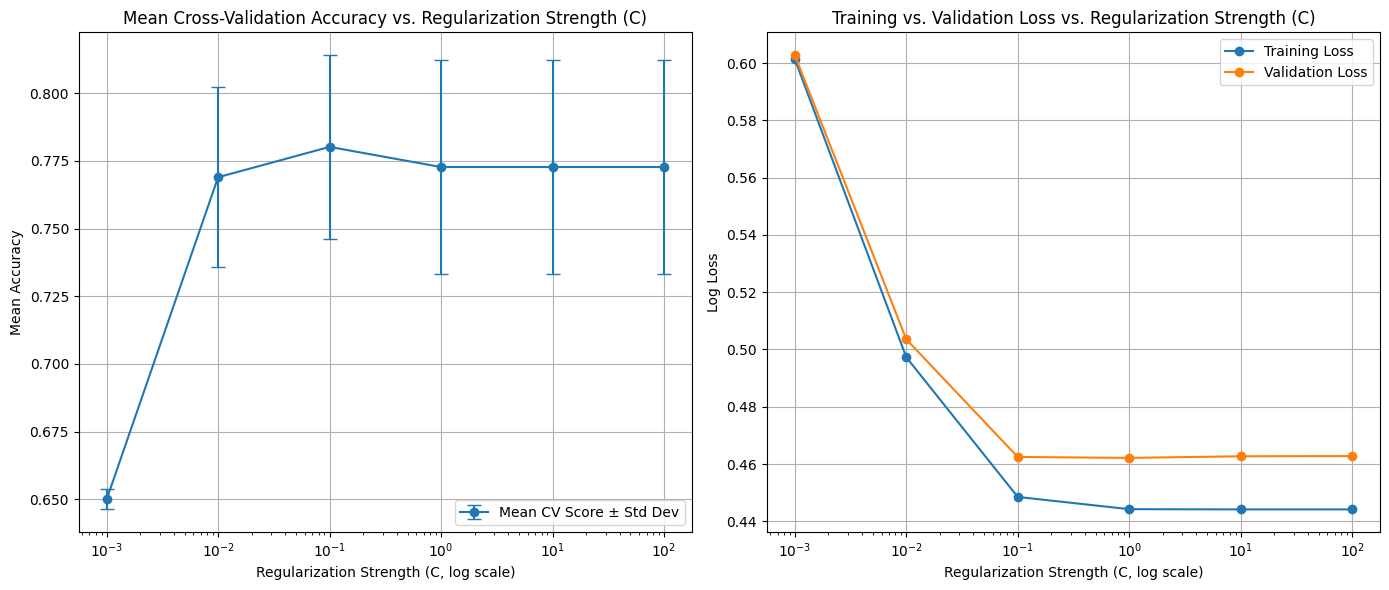

In [28]:
import matplotlib.pyplot as plt

# Create a figure with two subplots in a single row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- First Plot: Mean CV Score vs. C ---
ax1.errorbar(C_values, cv_scores, yerr=cv_std_devs, fmt='-o', capsize=5, label='Mean CV Score ± Std Dev')
ax1.set_xscale('log')
ax1.set_title('Mean Cross-Validation Accuracy vs. Regularization Strength (C)')
ax1.set_xlabel('Regularization Strength (C, log scale)')
ax1.set_ylabel('Mean Accuracy')
ax1.grid(True)
ax1.legend()

# --- Second Plot: Training vs. Validation Loss ---
ax2.plot(C_values, train_losses, label='Training Loss', marker='o')
ax2.plot(C_values, val_losses, label='Validation Loss', marker='o')
ax2.set_xscale('log')
ax2.set_title('Training vs. Validation Loss vs. Regularization Strength (C)')
ax2.set_xlabel('Regularization Strength (C, log scale)')
ax2.set_ylabel('Log Loss')
ax2.grid(True)
ax2.legend()

plt.tight_layout() # Adjusts subplot params for a tighter layout
plt.show()

**Q6 — Final comparison & analysis**

**a. Summarize the error estimates from: holdout validation, repeated holdout (mean ± std), 5‑fold CV, 10‑fold CV, LOOCV, and bootstrap. Present as a table.**
<table>
<tr>
    <td>Method</td> <td>Holdout Validation</td> <td>Repeated Holdout</td> <td>5-fold Stratified CV</td> <td>10-fold Stratified CV</td> <td> LOOCV</td> <td>Bootstrap</td> 
</tr>
<tr>
    <td>Prediction Error</td> <td>0.2130</td> <td>0.2216</td> <td>0.2272</td> <td>0.2252</td> <td>0.2253</td> <td>0.2535</td>
</tr>
<tr>
    <td>Standard Estimation</td> <td>0</td> <td>0.0385</td> <td>0.0395</td> <td>0.0536</td> <td>0.4178</td> <td>0.0267</td>
</tr>
</table>

**b. For each method, comment on bias, variance, compute cost, and practical recommendations (when to use which method).**

* Holdout Validation:
    * Bias: accuracy at training set = 0.78 (Less biased)
    * Variance: Error at training set = 0.22 & Error at validation set = 0.21 (small difference), std=0 => so low variance
    * Compute Cost: 0.0S
    * Practical Recommendation: This method is best used for very large datasets where a single split provides a sufficiently representative training and test set. It's also useful for a quick, initial assessment of a model's performance.

* Repeated Holdout:
    * Bias: accuracy at training set = 0.7844 (Less biased)
    * Variance: Error at training set = 0.2256 & Error at validation set =0.2216 (small difference), std =0.0385  => so low variance
    * Compute Cost: 0.1s
    * Practical Recommendation: This is a good method to get a more reliable performance estimate than a single holdout, especially for small-to-medium-sized datasets, as it reduces the risk of having a "lucky" or "unlucky" split.

* 5-fold Stratified CV:
    * Bias: accuracy at training set = 0.7669 (Less biased)
    * Variance: Error at training set = 0.2331 & Error at validation set = 0.2272 (a slight difference), std =0.0395v => so moderate variance
    * Compute Cost: 0.2s
    * Practical Recommendation:  This method is suitable for small to medium-sized imbalanced datasets. It provides a good balance between low bias and low variance at a reasonable computational cost.

* 10-fold Stratified CV:
    * Bias: accuracy at training set = 0.7743 (Less biased)
    * Variance: Error at training set = 0.2557 & Error at validation set = 0.3148 (moderate difference), std = 0.0536  => so moderate variance
    * Compute Cost: 0.2s
    * Practical Recommendation:  This is a good choice for imbalanced datasets where we need a very reliable and robust estimate of the model's performance, as it trains the model on a very large portion of the data in each iteration.

* LOOCV:
    * Bias: accuracy at training set = 0.7871 (Less biased)
    * Variance: Error at training set = 0.2129 & Error at validation set = 0.2253 (small difference), std = 0.4178 => Extremely high variance
    * Compute Cost: 5.1s
    * Practical Recommendation: Due to its high compute cost and high variance, it is rarely used in practice for model evaluation. It is mostly a theoretical concept or a method used for small datasets where a highly unbiased estimate is crucial.

* Bootstrap:
    * Bias: accuracy at training set = 0.7677 (Less biased)
    * Variance: Error at training set = 0.2315 & Error at validation set = 0.2540, std = 0.0267 => Low variance
    * Compute Cost: 6.4s
    * Practical Recommendation: The bootstrap method is often used for estimating the confidence intervals of a model's performance. It is a good alternative to cross-validation when a very stable and precise estimate is needed, particularly for small datasets or when the data distribution is complex.

**c. Pick the method you trust most for estimating true test error in this dataset and justify.**

For estimating the true test error for this dataset, **10-fold stratified cross-validation** is the most recommended method because:

1.  **Bias-Variance Trade-off:** This method provides the best balance between bias and variance. The model is trained on a large portion of the data (90% in each fold), which keeps the bias low. While the results showed a slightly higher standard deviation for 10-fold compared to 5-fold, in most cases, 10-fold gives a more stable estimate than methods like LOOCV.
2.  **Robustness:** By running the validation on 10 different folds, it provides a much more robust and reliable estimate than a single holdout validation. It ensures that every data point gets a chance to be in the validation set.
3.  **Addresses Imbalance:** The "stratified" component is critical for the dataset. It ensures that the class distribution is maintained in each fold, preventing a scenario where a fold might have very few or no instances of the minority class. This makes the performance estimate, particularly metrics like recall and F1-score, much more trustworthy.
4.  **Computational Efficiency:** Although more expensive than a single holdout, 10-fold CV is significantly faster and more practical than LOOCV or bootstrap, making it a feasible and widely used method.

In summary, while all the methods have their pros and cons, **10-fold stratified cross-validation is good** for evaluating a model's performance on this kind of imbalanced datasets. It gives a reliable, unbiased, and practical estimate of the true test error.